# reading tensorboard files for compiling the results

In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import FEATURES_DIR
from analyses.ridge_regression_decoding_mni_mmda import NUM_CV_SPLITS, REGRESSION_MODEL_PYTORCH, REGRESSION_MODEL_SKLEARN, HyperParameters

plt.style.use('seaborn-v0_8-deep')
from glob import glob
from glob import escape as gescape
from scipy.stats import sem
import pickle
from tqdm import tqdm

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_mode = "train"
results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/{training_mode}')

model_names = [
    # 'RESNET152_AVGPOOL',
   #  'VITL16_ENCODER',
   #  'CLIP_V',
   # 'BERT_LARGE',
   #  'GPT2XL_AVG',
   'CLIP_L',
    # 'RESNET152_AVGPOOL_PCA768',
     # 'GPT2XL_AVG_PCA768',
     # 'VITL16_ENCODER_PCA768',
    # 'CLIP_L_PCA768',
    # 'CLIP_V_PCA768'
]

# subjects = ['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-07']
subjects = ['sub-01', 'sub-02']

## best decoding accuracy for each HP across training epochs
- find the best epoch based on the testing MSE loss
- obtain the distance matrix corresponding to that epoch
- calculate accuracy

In [45]:
REGRESSION_MODELS = [REGRESSION_MODEL_PYTORCH, REGRESSION_MODEL_SKLEARN]

distance_metric  = ['cosine', 'euclidean'][0]
metrics   = ['val_loss', 'val_acc_cosine', 'val_rsa', f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images', 'rsa']

all_dfs = []

for regression_model in REGRESSION_MODELS:
    data = []
    for row, model_name in enumerate(model_names):
        for subjectidx, subject in enumerate(subjects):
            results_file_path = os.path.join(results_root_dir, regression_model, subject, model_name)
            result_files = sorted(glob(f"{results_file_path}/**/results.p"))
            for result_file_path in tqdm(result_files):
                if "full_train" in result_file_path:
                    hp_str = result_file_path.split(model_name)[1][1:]
                    hp_str = hp_str[:hp_str.index('/')]
                elif "best_hp" in result_file_path:
                    # TODO
                    continue
                else:
                    hp_str = result_file_path.split(model_name)[1][1:]
                    hp_str = hp_str.split("fold")[0]
                    
                # print(hp_str)
                
                results = pickle.load(open(result_file_path, 'rb'))

                for key in results.keys():
                    if key in metrics:
                        data.append({
                            "subject": subject,
                            "hp": hp_str,
                            "model": model_name,
                            "metric": key,
                            "value": results[key],
                            "regression_model": regression_model,
                        })   

    df = pd.DataFrame.from_records(data)
    
    df_mean = df.copy()
    df_mean["subject"] = "average"
    df = pd.concat((df, df_mean))
    all_dfs.append(df)

all_data = pd.concat(all_dfs)

all_data["hp_str"] = all_data.regression_model + '_' + all_data.hp


100%|██████████| 12/12 [00:00<00:00, 286.39it/s]


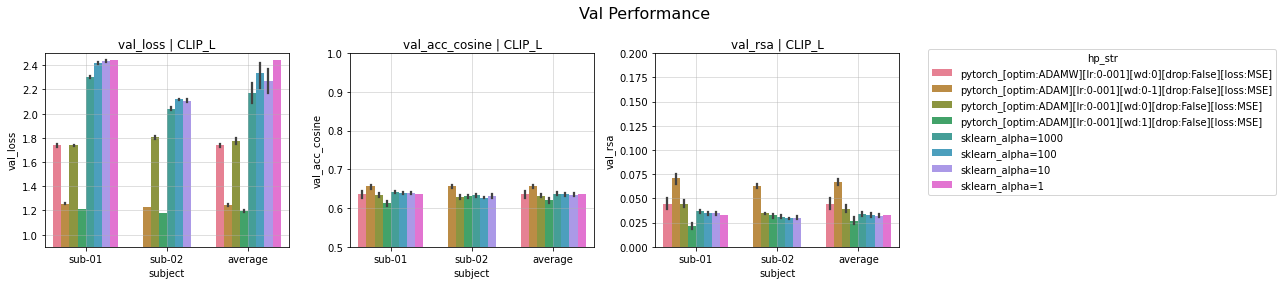

In [46]:
# data_to_plot = all_data[all_data.regression_model == REGRESSION_MODEL_SKLEARN]
data_to_plot = all_data
metrics   = ['val_loss', 'val_acc_cosine', 'val_rsa']

fig, axes = plt.subplots(len(model_names), len(metrics), figsize=(len(metrics)*6, len(model_names)*4), squeeze=False)

for row, model_name in enumerate(model_names):
    for col, metric in enumerate(metrics):
        legend = True if (row == 0 and col == len(metrics) - 1) else False
        data = data_to_plot[(data_to_plot.metric==metric) & (data_to_plot.model == model_name)].dropna()
        sns.barplot(ax=axes[row,col], data=data, x="subject", y="value", hue="hp_str", legend=legend)
        if legend:
            sns.move_legend(axes[row,col], bbox_to_anchor=(1.1, 1.05), loc="upper left")
        axes[row,col].grid(alpha=0.5)
        axes[row,col].set_ylabel(f'{metric}')
        axes[row,col].set_title(f'{metric} | {model_name}')
        if "rsa" in metric:
            axes[row,col].set_ylim(bottom=0, top=0.2)
        elif metric == "val_loss":
            axes[row,col].set_ylim(bottom=0.9, top=2.5)
        else:
            axes[row,col].set_ylim(bottom=0.5, top=1)

fig.suptitle("Val Performance", fontsize=16)
plt.tight_layout()
plt.savefig("val_performance.png", dpi=300)


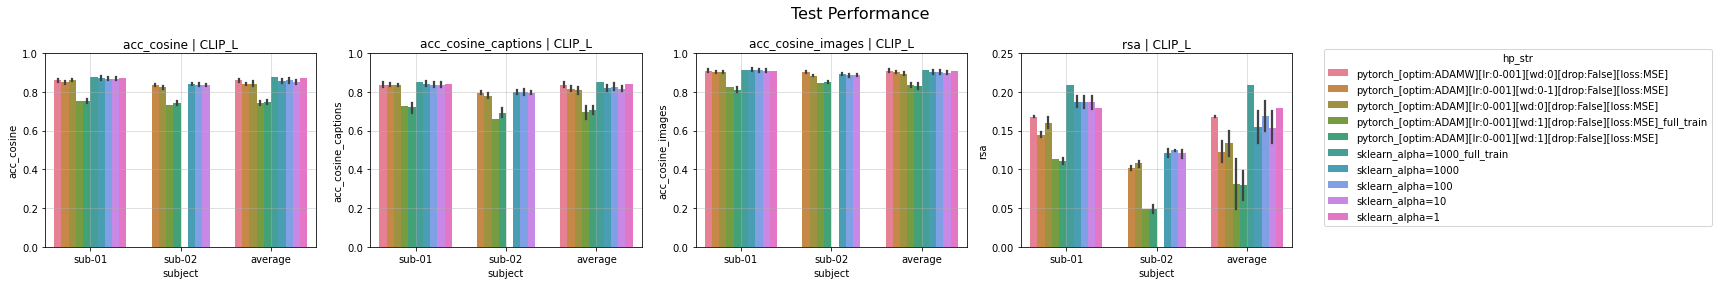

In [47]:
# data_to_plot = all_data[all_data.regression_model == REGRESSION_MODEL_SKLEARN]
data_to_plot = all_data

metrics   = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images', 'rsa']

fig, axes = plt.subplots(len(model_names), len(metrics), figsize=(len(metrics)*6, len(model_names)*4), squeeze=False)

for row, model_name in enumerate(model_names):
    for col, metric in enumerate(metrics):
        legend = True if (row == 0 and col == len(metrics) - 1) else False
        data = data_to_plot[(data_to_plot.metric==metric) & (data_to_plot.model == model_name)].dropna()
        sns.barplot(ax=axes[row,col], data=data, x="subject", y="value", hue="hp_str", legend=legend)
        if legend:
            sns.move_legend(axes[row,col], bbox_to_anchor=(1.1, 1.05), loc="upper left")
        axes[row,col].grid(alpha=0.5)
        axes[row,col].set_ylabel(f'{metric}')
        axes[row,col].set_title(f'{metric} | {model_name}')
        if "rsa" in metric:
            axes[row,col].set_ylim(bottom=0, top=0.25)
        elif metric == "val_loss":
            axes[row,col].set_ylim(bottom=0.9, top=1.3)
        else:
            axes[row,col].set_ylim(bottom=0, top=1)

fig.suptitle("Test Performance", fontsize=16)
plt.tight_layout()
plt.savefig("test_performance.png", dpi=300)


## 

# imagery decoding

In [43]:
# load subjects best module
# load imagery beta files
# load all latent vectors
# search for the nearest neighbors

In [68]:
from utils import IMAGERY_SCENES
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')
from glob import glob
from glob import escape as gescape
from ridge_regression_decoding_mni_mmda import HyperParameters, LinearNet, COCOBOLDDataset
import torch
import pickle
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose
import nibabel as nib

def get_nearest_neighbors_indices(vector, dataset_vectors, n_neighbors, metric='cosine'):
    r"""
    extracts neighboring vectors of each given vector with respect to the dataset.
    metric defines the distance metric for finding neighbors
    """
    # if vector is 2-dim, the neighbors will be returned for each sample
    if np.ndim(vector) == 1:
        vector = vector[np.newaxis,:]
    
    dists = cdist(vector, dataset_vectors, metric=metric)
    nearests_ids   = np.argsort(dists, axis=1)[:, :n_neighbors]
    nearests_dists = np.sort(dists, axis=1)[:, :n_neighbors]

    return nearests_ids, nearests_dists

def fetch_image(sid, ds_root):
    file_name = f"{sid:012d}.jpg"
    image_add = list(glob(os.path.join(ds_root, '*', file_name)))
    return plt.imread(image_add[0])

def show_neighboring_images(neighboring_ids, distances, imagery_scene):
    rows = int(np.ceil(len(neighboring_ids)/10))
    fig, axes = plt.subplots(rows, 10, figsize=(30,rows*3), facecolor='white', squeeze=False)
    fig.suptitle(imagery_scene, fontsize=20)
    row = 0
    col = 0
    for c in range(len(neighboring_ids)):
        axes[row,col].imshow(fetch_image(neighboring_ids[c], '/home/milad/datasets/coco2017/images'))
        axes[row,col].set_axis_off()
        axes[row,col].set_title(f"{distances[c]:.4f}")
        col += 1
        if col == 10:
            row += 1
            col = 0
    plt.tight_layout()
    # plt.show()
    plt.savefig('temp.jpg', dpi=96)
    plt.close()

def decode_imagery(net, imagery_loader, device):
    net.eval()
    predictions = []
    with torch.no_grad():
        for data in imagery_loader:
            test_inputs, _,_, test_ids = data
            outputs = net(test_inputs.to(device))
            predictions.append(outputs.cpu().numpy())
        predictions = np.concatenate(predictions, axis=0)
    return predictions

class Normalize():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, x):
        return ((x-self.mean)/self.std).astype(np.float32).squeeze()

def to_tensor(v):
    return torch.from_numpy(v)

def normalize_vectors(latent_vectors, normalizer):
    nvects = []
    for v in latent_vectors:
        nvects.append(normalizer(v).numpy())
    return np.array(nvects)



In [69]:
# subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-07']
# model_names = ['ViT-L14-336px','ViTL16_GPT2XL', 'RESNET152_GPT2XL']
# latent_vector_files = {
#     "RESNET152_AVGPOOL_PCA768" :os.path.join(FEATURES_DIR, "resnet/resnet152_avgpool_selected_coco_crop_pca_768.pickle"),
#     # "RESNET152_AVGPOOL"        :os.path.join(FEATURES_DIR, "resnet/resnet152_avgpool_selected_coco_crop.pickle"),
#     "GPT2XL_AVG_PCA768"        :os.path.join(FEATURES_DIR, "gpt/gpt2_xl_avg_selected_coco_pca_768.pickle"),
#     "GPT2XL_AVG"               :os.path.join(FEATURES_DIR, "gpt/gpt2_xl_avg_selected_coco.pickle"),
#     "VITL16_ENCODER_PCA768"    :os.path.join(FEATURES_DIR, "vit/vit_l_16_encoder_selected_coco_crop_pca_768.pickle"),
#     "VITL16_ENCODER"           :os.path.join(FEATURES_DIR, "vit/vit_l_16_encoder_selected_coco_crop.pickle"),
#     "CLIP_L_PCA768"            :os.path.join(FEATURES_DIR, "clip/clip_l_VITL14336px_selected_coco_dataset_crop_pca_768.pickle"),
#     "CLIP_L"                   :os.path.join(FEATURES_DIR, "clip/clip_l_VITL14336px_selected_coco_dataset_crop.pickle"),
#     "CLIP_V_PCA768"            :os.path.join(FEATURES_DIR, "clip/clip_v_VITL14336px_selected_coco_dataset_crop_pca_768.pickle"),
#     "CLIP_V"                   :os.path.join(FEATURES_DIR, "clip/clip_v_VITL14336px_selected_coco_dataset_crop.pickle"),
# }

# two_stage_glm_dir   = f'/mnt/HD1/milad/multimodal_decoding/glm_manual/two-stage-mni/'
# bold_std_mean_name  = f'bold_mean_std'
# netowrks_base_dir   = f'/mnt/HD1/milad/multimodal_decoding/regression_results_mni'


In [14]:
HPs = [
    HyperParameters(optim_type='SGD', lr=0.010, wd=0.00, dropout=False, loss='MSE'),
    # HyperParameters(optim_type='SGD', lr=0.050, wd=0.00, dropout=False, loss='MSE'),
    # HyperParameters(optim_type='SGD', lr=0.010, wd=0.01, dropout=False, loss='MSE'),
    # HyperParameters(optim_type='SGD', lr=0.050, wd=0.01, dropout=False, loss='MSE'),
]

### decoding images from imagery

In [15]:
def decode_imagery_vision_to_vision_decoder(subject, model_name, hp, netowrks_base_dir):
    model_std_mean_name = f'{model_name}_mean_std'
    std_mean_dir        = f'/mnt/HD1/milad/multimodal_decoding/glm_manual/two-stage-mni/{subject}'

    # preparing the data transforms
    with open(latent_vector_files[model_name], 'rb') as handle:
        latent_vectors = pickle.load(handle)

    stim_ids = list(sorted(latent_vectors.keys()))
    vision_vectors   = [latent_vectors[sid]['visual_feature'] for sid in stim_ids]
    # language_vectors = [latent_vectors[sid]['lingual_feature'] for sid in stim_ids]

    # bold images
    with open(os.path.join(std_mean_dir, f'{bold_std_mean_name}_train_images.pickle'), 'rb') as handle:
        bold_mean_std = pickle.load(handle)
    bold_images_transform = Compose([
        Normalize(bold_mean_std['mean'], bold_mean_std['std']),
        to_tensor
    ])

    # # bold captions
    # with open(os.path.join(std_mean_dir, f'{bold_std_mean_name}_train_captions.pickle'), 'rb') as handle:
    #     bold_mean_std = pickle.load(handle)
    # bold_captions_transform = Compose([
    #     Normalize(bold_mean_std['mean'], bold_mean_std['std']),
    #     to_tensor
    # ])

    # latent images
    with open(os.path.join(std_mean_dir, f'{model_std_mean_name}_train_images.pickle'), 'rb') as handle:
        model_mean_std = pickle.load(handle)
    latent_images_transform = Compose([
        Normalize(model_mean_std['mean'], model_mean_std['std']),
        to_tensor
    ])

    # # latent captions
    # with open(os.path.join(std_mean_dir, f'{model_std_mean_name}_train_captions.pickle'), 'rb') as handle:
    #     model_mean_std = pickle.load(handle)
    # latent_captions_transform = Compose([
    #     Normalize(model_mean_std['mean'], model_mean_std['std']),
    #     to_tensor
    # ])


    imagery_to_vision_dataset = COCOBOLDDataset(two_stage_glm_dir, subject, latent_vectors, f'imagery', transform=bold_images_transform)
    imagery_to_vision_dataset.preload()
    imagery_to_vision_loader  = DataLoader(imagery_to_vision_dataset,  batch_size=len(imagery_to_vision_dataset), num_workers=0, shuffle=False)

    # imagery_to_captions_dataset = COCOBOLDDataset(two_stage_glm_dir, subjects[0], latent_vectors, f'imagery', transform=bold_captions_transform)
    # imagery_to_captions_dataset.preload()
    # imagery_to_captions_loader  = DataLoader(imagery_to_captions_dataset,  batch_size=len(imagery_to_captions_dataset), num_workers=0, shuffle=False)


    checkpoint = list(glob(os.path.join(gescape(os.path.join(netowrks_base_dir, subject, model_name, 'networks', hp.get_hp_string())), f'net_best_vision_vision*')))[0]
    net_vision = LinearNet(imagery_to_vision_loader.dataset.bold_dim_size, imagery_to_vision_loader.dataset.latent_dim_size)
    net_vision.load_state_dict(torch.load(checkpoint, map_location='cpu'))

    predictions = decode_imagery(net_vision, imagery_to_vision_loader, 'cpu')

    normalized_vision_vectors = normalize_vectors(vision_vectors, latent_images_transform)

    neighbors, distances = get_nearest_neighbors_indices(predictions-predictions.mean(axis=0), normalized_vision_vectors, 20)
    # neighbors, distances = get_nearest_neighbors_indices(predictions, normalized_vision_vectors, 20)

    for i in range(3):
        show_neighboring_images([stim_ids[a] for a in neighbors[i]], distances[i], IMAGERY_SCENES[subject][i][0])


In [16]:
decode_imagery_vision_to_vision_decoder(subjects[0], model_names[0], HPs[0], netowrks_base_dir)

KeyError: 'ViT-L14-336px'

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[1], model_names[0], HPs[0], netowrks_base_dir)

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[3], model_names[0], HPs[0], netowrks_base_dir)

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[4], model_names[0], HPs[0], netowrks_base_dir)

In [ ]:
decode_imagery_vision_to_vision_decoder(subjects[5], model_names[0], HPs[0], netowrks_base_dir)